# Image Captioning with BLIP and Flickr8k

This notebook demonstrates how to caption images using Hugging Face
libraries with the **BLIP base** model on the Flickr8k dataset.
We load the data, split it into train/validation/test, generate captions,
and evaluate with the BLEU metric.

In [2]:
# !pip install -q transformers datasets torchvision torch matplotlib evaluate
!pip install -qU datasets

## Load the Flickr8k Dataset

In [3]:
from datasets import load_dataset

flickr8k = load_dataset("jxie/flickr8k")

train_ds = flickr8k['train']
val_ds = flickr8k['validation']
test_ds = flickr8k['test']
print(f"Train split: {len(train_ds)} instances")
print(f"Validation split: {len(val_ds)} instances")
print(f"Test split: {len(test_ds)} instances")


Generating train split:   0%|          | 0/6000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Train split: 6000 instances
Validation split: 1000 instances
Test split: 1000 instances


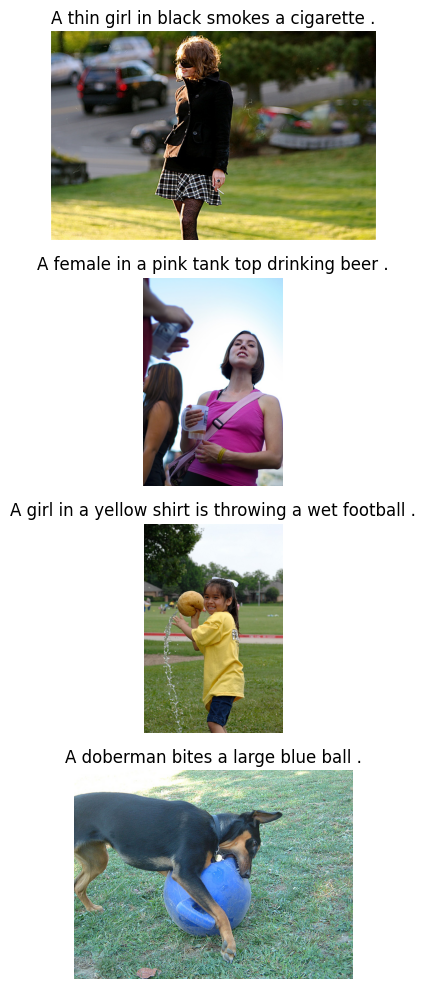

In [9]:
import random

from PIL import Image
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, figsize=(10, 10))
indices = random.sample(range(len(train_ds)), 4)

for ax, idx in zip(axes.flatten(), indices):
    example = train_ds[idx]
    # Access the PIL image object directly
    img = example['image'].convert('RGB')
    ax.imshow(img)
    # The dataset provides multiple captions under 'caption_0' to 'caption_4'
    ax.set_title(example['caption_0'])
    ax.axis('off')

plt.tight_layout()
plt.show()

## Generate Captions with BLIP base

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

processor = BlipProcessor.from_pretrained('Salesforce/blip-image-captioning-base')
model = BlipForConditionalGeneration.from_pretrained('Salesforce/blip-image-captioning-base')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

example = train_ds[0]
img = Image.open(example['image']).convert('RGB')
inputs = processor(images=img, return_tensors="pt").to(device)
with torch.no_grad():
    out = model.generate(**inputs)
caption = processor.decode(out[0], skip_special_tokens=True)
print('Caption:', caption)


## Evaluate the Model

In [ ]:
import evaluate
import matplotlib.pyplot as plt

bleu = evaluate.load('bleu')

def generate_caption(img_path):
    img = Image.open(img_path).convert("RGB")
    inputs = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        out = model.generate(**inputs)
    return processor.decode(out[0], skip_special_tokens=True)

preds, refs = [], []
for ex in test_ds.select(range(100)):
    preds.append(generate_caption(ex['image']))
    refs.append([ex['text']])

result = bleu.compute(predictions=preds, references=refs)
print("BLEU:", result["bleu"])

plt.bar(["BLEU"], [result["bleu"]])
plt.ylim(0,1)
plt.title("BLEU score on Flickr8k test set")
plt.show()
